# Facies classification using Machine Learning
## Introduction

Author: [Anjum Sayed](https://uk.linkedin.com/in/anjum-sayed-b63a151b). My prediction approach is as follows:

1. "Upsampling" the log data to a more conventional sample rate
2. Testing different classifiers:
    1. SVM (using GridSearchCV to find best parameters)
    2. DecisionTree (using GridSearchCV to find best parameters)
    3. XGBoost
    4. Naive Bayes
    5. AdaBoost 
    6. RandomForest
    7. Nearest neighbour (using GridSearchCV to find best parameters)
    8. DNN TensorFlow classifier
    9. LSTM TensorFlow classifier (TODO)
3. Taking the 5 best classifiers and creating an ensemble majority vote classifier

There are many ways to improve on my method. See the future work at the end section for ideas.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `facies_vectors.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type. 

In [2]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [3]:
# Drop the rows with missing PEF values
training_data.dropna(inplace=True)

In [4]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables. Looking at the count values, there are 3232 feature vectors in the training set.

These are the names of the 10 training wells in the Council Grove reservoir. Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone.

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial. We also create the abbreviated facies labels, and add those to the facies_vectors dataframe.

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

Let's take a look at the data from individual wells in a more familiar log plot form. We will create plots for the five well log variables, as well as a log for facies labels. The plots are based on the those described in Alessandro Amato del Monte's excellent tutorial.

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 'SiSh', ' MS ', ' WS ', ' D  ', ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`. 

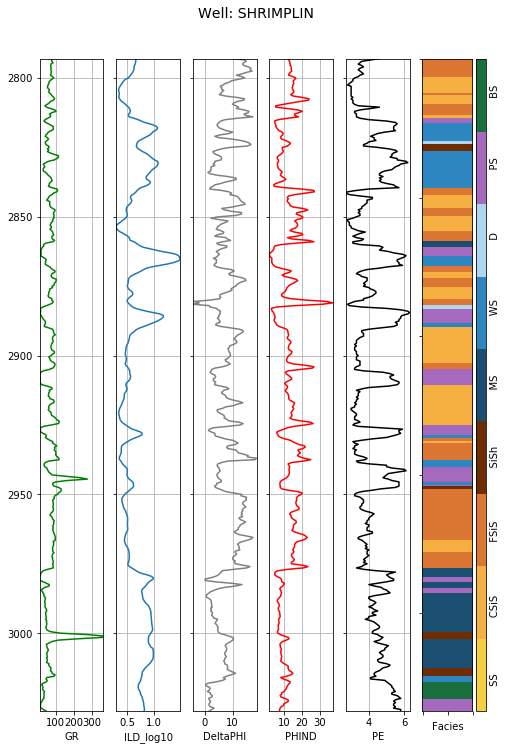

In [7]:
make_facies_log_plot(training_data[training_data['Well Name'] == 'SHRIMPLIN'], facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

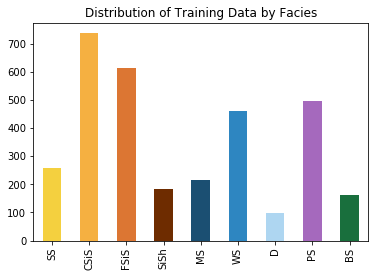

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

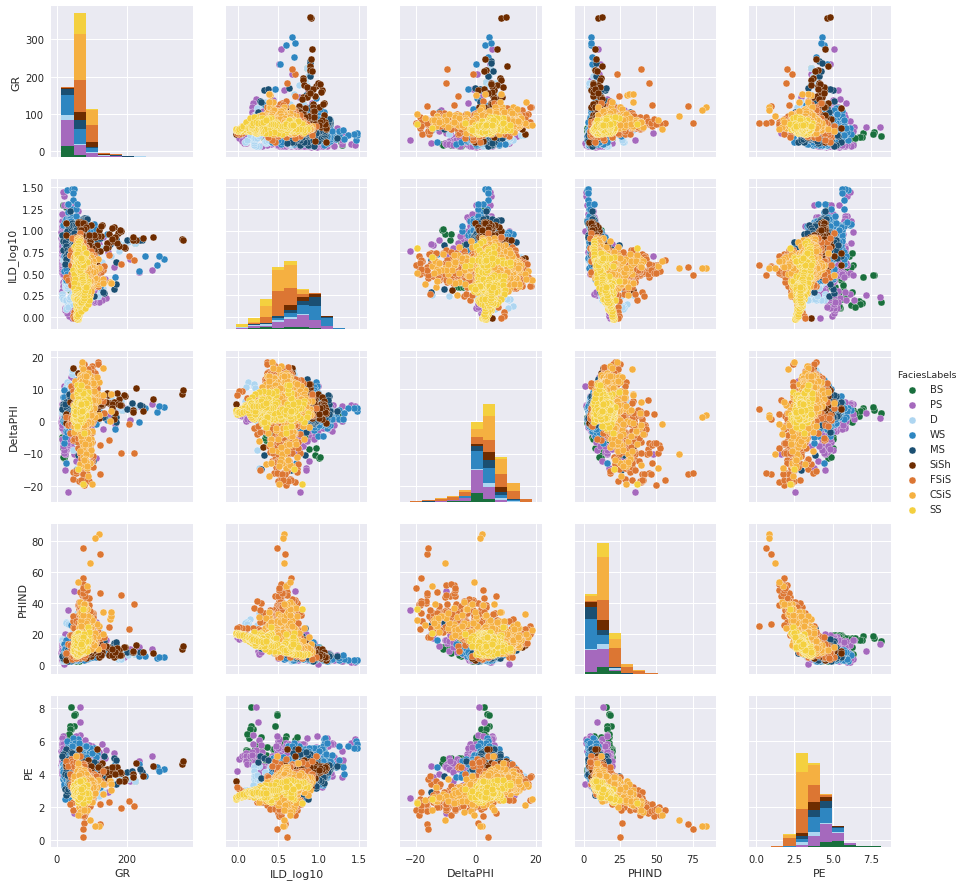

In [9]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## "Upsampling" the dataset
The supplied training data has a sampling rate of 0.5m, which is lower than the industry standard of 0.1524m. This means the the number of observations is a little on the small side, meaning that many ML classifiers will always perform poorly, especially with high entropy datasets.

One workaround to this will be to increase the sampling rate to 0.1m, by using a cubic spline to fill in the gaps in the data. Making up data is generally a no-no, but since wireline logs are generally heavily smoothed by the vendors, this additional step shouldn't add too much error, but will give us 5x more data to play with. We'll do this for each individual well (rather than the whole dataset) to prevent interpolation between wells.

In [10]:
upsampled_data = pd.DataFrame()
for well in training_data['Well Name'].unique():
    df = training_data[training_data['Well Name'] == well]
    df.index = np.arange(0, 5*len(df), 5)
    upsampled_df = pd.DataFrame(index=np.arange(0, 5*len(df)))
    upsampled_df = upsampled_df.join(df)
    upsampled_df.interpolate(method='cubic', limit=4, inplace=True)
    upsampled_df.fillna(method="pad", limit=4, inplace=True)
    upsampled_df.drop_duplicates(inplace=True)
    if len(upsampled_data) == 0:
        upsampled_data = upsampled_df
    else:
        upsampled_data = upsampled_data.append(upsampled_df, ignore_index=True)

upsampled_data["Facies"] = upsampled_data["Facies"].round()
upsampled_data["Facies"] = upsampled_data["Facies"].astype(int)
upsampled_data["NM_M"] = upsampled_data["NM_M"].round()
upsampled_data["NM_M"] = upsampled_data["NM_M"].astype(int)

# Sometimes a small number of the facies are labelled as 0 or 10 - these need to be removed
upsampled_data = upsampled_data[upsampled_data.Facies != 0]
upsampled_data = upsampled_data[upsampled_data.Facies != 10]
upsampled_data.loc[:,'FaciesLabels'] = upsampled_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [11]:
upsampled_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450000,0.664000,9.900000,11.915000,4.600000,1,1.000000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.1,79.284515,0.663545,11.150359,12.015714,4.546545,1,0.996012,FSiS
2,3,A1 SH,SHRIMPLIN,2793.2,79.937114,0.662987,12.190536,12.139619,4.460793,1,0.991895,FSiS
3,3,A1 SH,SHRIMPLIN,2793.3,79.753455,0.662357,13.035533,12.278167,4.351767,1,0.987673,FSiS
4,3,A1 SH,SHRIMPLIN,2793.4,79.079198,0.661685,13.700354,12.422809,4.228495,1,0.983367,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
16122,5,C LM,CHURCHMAN BIBLE,3122.1,51.177622,0.964821,3.026104,7.597464,3.161609,2,0.659412,MS
16123,5,C LM,CHURCHMAN BIBLE,3122.2,50.791689,0.964974,2.945037,7.451181,3.179267,2,0.657823,MS
16124,5,C LM,CHURCHMAN BIBLE,3122.3,50.407644,0.965716,2.845018,7.256165,3.206420,2,0.656228,MS
16125,5,C LM,CHURCHMAN BIBLE,3122.4,50.121933,0.967306,2.731266,6.999433,3.244515,2,0.654622,MS


Let's check if the facies distributions still look right

In [12]:
upsampled_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,4.420233,2875.779266,66.132765,0.642385,3.562926,13.488510,3.724287,1.498325,0.520044
std,2.492889,130.886683,30.795497,0.241821,5.207364,7.684145,0.894569,0.500013,0.284700
min,1.000000,2573.500000,12.759470,-0.026553,-21.923002,-1.112217,0.058033,1.000000,-0.096527
25%,2.000000,2791.000000,46.939636,0.490246,1.144971,8.359510,3.113000,1.000000,0.279000
50%,4.000000,2893.600003,65.816922,0.624654,3.461482,12.138445,3.546221,1.000000,0.525477
75%,6.000000,2980.000000,79.864096,0.812950,6.483459,16.492567,4.306479,2.000000,0.761796
max,9.000000,3122.500000,375.701116,1.487703,20.032203,84.606003,8.094000,2.000000,1.201765


SS      1321
CSiS    3650
FSiS    2967
SiSh     968
MS      1149
WS      2261
D        748
PS      2200
BS       858
Name: Facies, dtype: int64

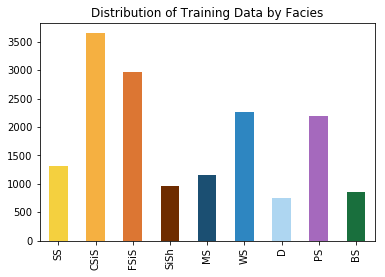

In [13]:
facies_counts = upsampled_data['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, title='Distribution of Training Data by Facies')
facies_counts

Looks good! We'll now use this upsampled data as our training data

In [14]:
training_data = upsampled_data

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [15]:
correct_facies_labels = training_data['Facies'].values
well_names = training_data['Well Name']

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,66.132765,0.642385,3.562926,13.488510,3.724287,1.498325,0.520044
std,30.795497,0.241821,5.207364,7.684145,0.894569,0.500013,0.284700
min,12.759470,-0.026553,-21.923002,-1.112217,0.058033,1.000000,-0.096527
25%,46.939636,0.490246,1.144971,8.359510,3.113000,1.000000,0.279000
50%,65.816922,0.624654,3.461482,12.138445,3.546221,1.000000,0.525477
75%,79.864096,0.812950,6.483459,16.492567,4.306479,2.000000,0.761796
max,375.701116,1.487703,20.032203,84.606003,8.094000,2.000000,1.201765


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [16]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [17]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450000,0.664000,9.900000,11.915000,4.600000,1,1.000000
1,79.284515,0.663545,11.150359,12.015714,4.546545,1,0.996012
2,79.937114,0.662987,12.190536,12.139619,4.460793,1,0.991895
3,79.753455,0.662357,13.035533,12.278167,4.351767,1,0.987673
4,79.079198,0.661685,13.700354,12.422809,4.228495,1,0.983367
...,...,...,...,...,...,...,...
16122,51.177622,0.964821,3.026104,7.597464,3.161609,2,0.659412
16123,50.791689,0.964974,2.945037,7.451181,3.179267,2,0.657823
16124,50.407644,0.965716,2.845018,7.256165,3.206420,2,0.656228
16125,50.121933,0.967306,2.731266,6.999433,3.244515,2,0.654622


Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, correct_facies_labels, test_size=0.1, random_state=48)

## Training the SVM classifier

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine).  The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.  

The SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) takes a number of important parameters.  First we create a classifier using the default settings.  

In [19]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)
predicted_labels = clf.predict(X_test)

Now we can train the classifier using the training set we created above.

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [20]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    75    55     4                 1                     135
     CSiS    12   282    47           1     1                     343
     FSiS     6    92   189     1           1                     289
     SiSh           3     8    64     3    26     1     1         106
       MS           2     1    11    33    55     3     5         110
       WS                 2     8    11   166     3    38     1   229
        D                 1     3     3    15    35    24     1    82
       PS                 2     5     2    41     7   168     3   228
       BS                                   3     2    19    67    91

Precision  0.81  0.65  0.74  0.70  0.62  0.54  0.69  0.66  0.93  0.68
   Recall  0.56  0.82  0.65  0.60  0.30  0.72  0.43  0.74  0.74  0.67
       F1  0.66  0.73  0.70  0.65  0.40  0.62  0.53  0.70  0.82  0.66


The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [21]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [22]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [23]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.668940
Adjacent facies classification accuracy = 0.940484


# Cross validation using leave one well out
This function performs CV using the F1 score by leaving 1 well out. This is probably more appropraite for this dataset rather than CV based on a shuffled train/test dataset.

In [24]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

def LOWO_CV(estimator, parameters):
    logo = LeaveOneGroupOut()
    clf = GridSearchCV(estimator, parameters, n_jobs=-1, verbose=3, scoring="f1_micro",
                       cv=logo.split(scaled_features, correct_facies_labels, groups=training_data['Well Name']))
    clf.fit(scaled_features, correct_facies_labels)
    return clf    

# SVM Tuning

In [25]:
parameters = {'C': [.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000], 
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 
              'kernel': ['rbf']}  # This could be extended to the linear kernel but it takes a long time

clf_svr = SVC()
clf = LOWO_CV(clf_svr, parameters)

Fitting 8 folds for each of 60 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  9.6min finished


Let's plot the find the best results

In [26]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,param_kernel,params,rank_test_score,split0_test_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
14,5.299875,0.937375,0.484555,0.603398,5,0.01,rbf,"{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}",1,0.517875,...,0.452381,0.599265,0.436859,0.599597,0.495745,0.604996,0.540520,0.290967,0.050935,0.008078
54,12.820000,0.947875,0.483005,0.585804,10000,0.0001,rbf,"{'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}",2,0.517875,...,0.252976,0.576207,0.470772,0.586917,0.493191,0.588222,1.748016,0.292967,0.056922,0.010339
20,5.362750,0.935500,0.482198,0.612040,10,0.01,rbf,"{'C': 10, 'kernel': 'rbf', 'gamma': 0.01}",3,0.516385,...,0.488095,0.607880,0.427934,0.607233,0.491064,0.611966,0.589302,0.293832,0.049602,0.007843
37,6.544750,0.975125,0.481764,0.585233,100,0.001,rbf,"{'C': 100, 'kernel': 'rbf', 'gamma': 0.001}",4,0.514896,...,0.199405,0.574433,0.473003,0.587566,0.491915,0.586625,0.754445,0.306849,0.062365,0.011073
26,5.606125,0.973750,0.481640,0.620881,20,0.01,rbf,"{'C': 20, 'kernel': 'rbf', 'gamma': 0.01}",5,0.513406,...,0.491071,0.614088,0.430611,0.616742,0.495319,0.616904,0.624548,0.321492,0.047390,0.007816


C = 1000 and gamma = 1 seem to give the best F1 score. Let's try using these against the test dataset

In [27]:
clf_svm = SVC(C=5, gamma=0.01)
clf_svm.fit(X_train, y_train)
predicted_labels = clf_svm.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    73    59     2                 1                     135
     CSiS    18   251    69     3           1     1               343
     FSiS    10   100   174     4           1                     289
     SiSh           2     6    69          28           1         106
       MS           2     1    15          81     7     4         110
       WS           1     1    15     2   161     5    43     1   229
        D                 1     6     4    22    28    20     1    82
       PS           1     1     8     2    55     5   139    17   228
       BS                                   7     2    23    59    91

Precision  0.72  0.60  0.68  0.57  0.00  0.45  0.58  0.60  0.76  0.57
   Recall  0.54  0.73  0.60  0.65  0.00  0.70  0.34  0.61  0.65  0.59
       F1  0.62  0.66  0.64  0.61  0.00  0.55  0.43  0.61  0.70  0.57


C:\Users\sayea5\iPython Notebooks\2016-ml-contest-master\Anjum48\classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


# DecisionTree classifier
Decision trees are very powerful for high entropy datasets however they have an tendancy to overfit. One way of controlling this is by limiting the depth of the tree using the `max_depth` parameter. We can use `GridSearchCV` for this too.

In [28]:
from sklearn import tree

parameters = {'max_depth': np.arange(2, 35)}
clf_dt = tree.DecisionTreeClassifier()
clf = LOWO_CV(clf_dt, parameters)

Fitting 8 folds for each of 33 candidates, totalling 264 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed:    8.2s finished


In [29]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.038125,0.001125,0.460117,0.554294,4,{'max_depth': 4},1,0.469215,0.563014,0.311049,...,0.571429,0.555556,0.437751,0.559974,0.494043,0.544365,0.001536,0.000331,0.078100,0.011958
3,0.050625,0.001125,0.459682,0.593487,5,{'max_depth': 5},2,0.477656,0.613056,0.376701,...,0.559524,0.593944,0.414547,0.591672,0.479149,0.593886,0.007793,0.000331,0.048618,0.011411
4,0.063250,0.001000,0.448021,0.631131,6,{'max_depth': 6},3,0.485104,0.639424,0.383106,...,0.517857,0.622324,0.375279,0.634536,0.546809,0.627142,0.010674,0.000500,0.057665,0.006495
5,0.084125,0.001375,0.445912,0.671229,7,{'max_depth': 7},4,0.464250,0.670258,0.349079,...,0.517857,0.661219,0.430611,0.671205,0.469787,0.678333,0.018052,0.000484,0.054334,0.005669
6,0.096250,0.001375,0.445230,0.712028,8,{'max_depth': 8},5,0.485601,0.703785,0.357486,...,0.642857,0.697453,0.443552,0.714862,0.429362,0.720447,0.022482,0.000484,0.053878,0.010110


In [30]:
clf_dt = tree.DecisionTreeClassifier(max_depth=4)
clf_dt.fit(X_train, y_train)
predicted_labels = clf_dt.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    55    58    21                 1                     135
     CSiS    14   237    87     5                                 343
     FSiS     2    96   186     4           1                     289
     SiSh     1           7    48          49                 1   106
       MS           2     1    12          90     1     2     2   110
       WS                 2    17         183     1    22     4   229
        D                 1    31          36     7     5     2    82
       PS           1     1    26          70     2   114    14   228
       BS                       4          14          23    50    91

Precision  0.76  0.60  0.61  0.33  0.00  0.41  0.64  0.69  0.68  0.55
   Recall  0.41  0.69  0.64  0.45  0.00  0.80  0.09  0.50  0.55  0.55
       F1  0.53  0.64  0.63  0.38  0.00  0.54  0.15  0.58  0.61  0.52


C:\Users\sayea5\iPython Notebooks\2016-ml-contest-master\Anjum48\classification_utilities.py:13: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')


# Random Forest classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 7],
#               "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

clf_rf = RandomForestClassifier(n_estimators=200)
clf = LOWO_CV(clf_rf, param_grid)

Fitting 8 folds for each of 72 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  8.8min finished


In [34]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,3.880750,0.112500,0.503163,0.888122,True,gini,None,1,10,"{'criterion': 'gini', 'min_samples_leaf': 10, ...",...,0.791667,0.884265,0.509594,0.881637,0.580851,0.885347,0.356372,0.026772,0.088049,0.003984
10,4.270375,0.117000,0.501489,0.974009,True,gini,None,1,3,"{'criterion': 'gini', 'min_samples_leaf': 3, '...",...,0.830357,0.974154,0.514502,0.973057,0.561702,0.972916,0.249210,0.026594,0.088710,0.001032
29,11.114875,0.105625,0.501489,0.891480,True,entropy,None,1,10,"{'criterion': 'entropy', 'min_samples_leaf': 1...",...,0.791667,0.888826,0.518072,0.885599,0.573191,0.888179,0.659645,0.025367,0.087378,0.004646
47,5.804750,0.108750,0.500372,0.931255,False,gini,None,1,10,"{'criterion': 'gini', 'min_samples_leaf': 10, ...",...,0.809524,0.929431,0.514056,0.928535,0.558298,0.929640,0.390167,0.024355,0.089608,0.002357
46,6.657500,0.125500,0.499628,0.994280,False,gini,None,1,3,"{'criterion': 'gini', 'min_samples_leaf': 3, '...",...,0.839286,0.994362,0.506470,0.995173,0.566383,0.993973,0.446568,0.033890,0.087485,0.000500


In [39]:
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=None, max_features=1, min_samples_leaf=10, bootstrap=False, 
                                criterion="gini")

clf_rf.fit(X_train, y_train)
predicted_labels = clf_rf.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   117    15     2                 1                     135
     CSiS         321    21                 1                     343
     FSiS          35   252     1           1                     289
     SiSh           3     9    86     1     4     1     2         106
       MS           1     1     7    80    18     1     2         110
       WS           1     1     4     1   207     4    11         229
        D                 2     1          16    47    14     2    82
       PS                 1           1     9     4   210     3   228
       BS                             1     2     2    17    69    91

Precision  1.00  0.85  0.87  0.87  0.95  0.80  0.80  0.82  0.93  0.87
   Recall  0.87  0.94  0.87  0.81  0.73  0.90  0.57  0.92  0.76  0.86
       F1  0.93  0.89  0.87  0.84  0.82  0.85  0.67  0.87  0.84  0.86


# Nearest Neighbours classifier
This classifer has two parameters that can be tuned: the number of neighbours to use, and the method of weighting the neighbours (uniform or distance based). We'll use GridSearchCV again to find the optimal set.

In [35]:
from sklearn import neighbors

parameters = {'n_neighbors': np.arange(1, 25), 'weights': ['uniform', 'distance']}
knn = neighbors.KNeighborsClassifier()
clf = LOWO_CV(knn, parameters)

Fitting 8 folds for each of 48 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:   15.1s finished


In [36]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
47,0.020250,0.155625,0.435430,0.999565,24,distance,"{'n_neighbors': 24, 'weights': 'distance'}",1,0.453823,0.999858,...,0.845238,0.999557,0.429273,0.999496,0.502979,0.999492,0.001561,0.057356,0.079974,0.000115
45,0.023000,0.152625,0.435182,0.999565,23,distance,"{'n_neighbors': 23, 'weights': 'distance'}",2,0.455809,0.999858,...,0.845238,0.999557,0.429273,0.999496,0.502553,0.999492,0.006576,0.052934,0.080527,0.000115
43,0.024625,0.154125,0.433755,0.999565,22,distance,"{'n_neighbors': 22, 'weights': 'distance'}",3,0.462264,0.999858,...,0.845238,0.999557,0.423472,0.999496,0.505532,0.999492,0.010049,0.058923,0.081599,0.000115
46,0.021750,0.150000,0.433011,0.820464,24,uniform,"{'n_neighbors': 24, 'weights': 'uniform'}",4,0.444886,0.824213,...,0.800595,0.818637,0.427934,0.815287,0.498298,0.814406,0.003455,0.053261,0.073887,0.004048
44,0.020500,0.154250,0.432949,0.826099,23,uniform,"{'n_neighbors': 23, 'weights': 'uniform'}",5,0.437934,0.830380,...,0.806548,0.823768,0.432396,0.820690,0.501277,0.819344,0.001871,0.057421,0.075261,0.004325
42,0.020250,0.143125,0.432080,0.828625,22,uniform,"{'n_neighbors': 22, 'weights': 'uniform'}",6,0.447368,0.832861,...,0.803571,0.826682,0.425257,0.822923,0.498723,0.823265,0.001561,0.051111,0.074517,0.003970
39,0.020250,0.151875,0.431770,0.999565,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",7,0.466733,0.999858,...,0.845238,0.999557,0.420794,0.999496,0.502128,0.999492,0.001854,0.055609,0.081836,0.000115
40,0.020375,0.153875,0.431646,0.833723,21,uniform,"{'n_neighbors': 21, 'weights': 'uniform'}",8,0.446375,0.838531,...,0.800595,0.831560,0.423472,0.828326,0.498298,0.827113,0.001867,0.061874,0.074634,0.004287
41,0.020875,0.143125,0.431336,0.999565,21,distance,"{'n_neighbors': 21, 'weights': 'distance'}",9,0.460278,0.999858,...,0.845238,0.999557,0.418563,0.999496,0.500000,0.999492,0.001900,0.051289,0.081546,0.000115
38,0.024375,0.141000,0.430778,0.837455,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",10,0.444886,0.842288,...,0.803571,0.834980,0.422579,0.831712,0.494043,0.830744,0.006873,0.049742,0.073696,0.004514


It looks like several different parameter combinations give the same score. We'll pick the one using the most neighbours: `n_neighbors=1` and `weights="distance"` (the latter has no effect with k=1)

In [38]:
clf_knn = neighbors.KNeighborsClassifier(24, weights="distance")
clf_knn.fit(X_train, y_train)
predicted_labels = clf_knn.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   126     6     2                 1                     135
     CSiS     3   310    30                                       343
     FSiS     3    22   262                 1           1         289
     SiSh                 8    91     3     4                     106
       MS                 1     5    87    14     2     1         110
       WS           2           7     9   197     3    10     1   229
        D                 2     1     2    11    49    15     2    82
       PS                 2     2     2     7     7   205     3   228
       BS                             1           2    12    76    91

Precision  0.95  0.91  0.85  0.86  0.84  0.84  0.78  0.84  0.93  0.87
   Recall  0.93  0.90  0.91  0.86  0.79  0.86  0.60  0.90  0.84  0.87
       F1  0.94  0.91  0.88  0.86  0.81  0.85  0.68  0.87  0.88  0.87


# Ensemble classifier

In [40]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('SVM', clf_svm), 
                                    ('DecisionTree', clf_dt), 
                                    ('KNN', clf_knn), 
                                    ('RandomForest', clf_rf)
                                   ], 
                        voting='hard')

eclf.fit(X_train, y_train)
predicted_labels = eclf.predict(X_test)

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   116    16     2                 1                     135
     CSiS     5   310    28                                       343
     FSiS     2    80   205     1           1                     289
     SiSh           1     8    88           9                     106
       MS           2     1     9    75    21     1     1         110
       WS           2          17     2   200     1     6     1   229
        D                 2     7          22    40     9     2    82
       PS           1     1     3     1    40     3   177     2   228
       BS                             1     5     2    18    65    91

Precision  0.94  0.75  0.83  0.70  0.95  0.67  0.85  0.84  0.93  0.81
   Recall  0.86  0.90  0.71  0.83  0.68  0.87  0.49  0.78  0.71  0.79
       F1  0.90  0.82  0.76  0.76  0.79  0.76  0.62  0.81  0.81  0.79


In [41]:
display_adj_cm(conf, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   132           2                 1                     135
     CSiS         343                                             343
     FSiS     2         285     1           1                     289
     SiSh           1     8    88           9                     106
       MS           2     1         105           1     1         110
       WS           2          17         209                 1   229
        D                 2     7                71           2    82
       PS           1     1     3     1               222         228
       BS                             1     5                85    91

Precision  0.99  0.98  0.95  0.76  0.98  0.93  0.99  1.00  0.97  0.96
   Recall  0.98  1.00  0.99  0.83  0.95  0.91  0.87  0.97  0.93  0.95
       F1  0.98  0.99  0.97  0.79  0.97  0.92  0.92  0.98  0.95  0.96


# Average test F1 score with leave one well out

In [42]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, classification_report

f1_eclf = []
logo = LeaveOneGroupOut()

for train, test in logo.split(scaled_features, correct_facies_labels, groups=well_names):  
    eclf.fit(scaled_features[train], correct_facies_labels[train])
    pred = eclf.predict(scaled_features[test])
    sc = f1_score(correct_facies_labels[test], pred, labels=np.arange(10), average='micro')
    
    well_name = well_names[test[0]]
    print("{}  {:.3f}".format(well_name, sc))
    f1_eclf.append(sc)
    
#     conf = confusion_matrix(correct_facies_labels[test], pred)
#     display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)
#     print("")
    
print("Average leave-one-well-out F1 Score: %6f" % (sum(f1_eclf)/(1.0*(len(f1_eclf)))))

NEWBY  0.536
CROSS H CATTLE  0.399
LUKE G U  0.545
Recruit F9  0.456
CROSS H CATTLE  0.457
NOLAN  0.699
SHANKLE  0.438
SHRIMPLIN  0.547
Average leave-one-well-out F1 Score: 0.509589


# Prediction
Let's use the full dataset to train the models and make the prediction

In [43]:
#Load testing data and standardise
test_data = pd.read_csv('../validation_data_nofacies.csv')
test_features = test_data.drop(['Well Name', 'Depth', "Formation"], axis=1)
scaled_test_features = scaler.transform(test_features)

In [44]:
eclf.fit(scaled_features, correct_facies_labels)
predicted_test_labels = eclf.predict(scaled_test_features)

# Save predicted labels
test_data['Facies'] = predicted_test_labels
test_data.to_csv('Anjum48_Prediction_Submission_v2.csv')

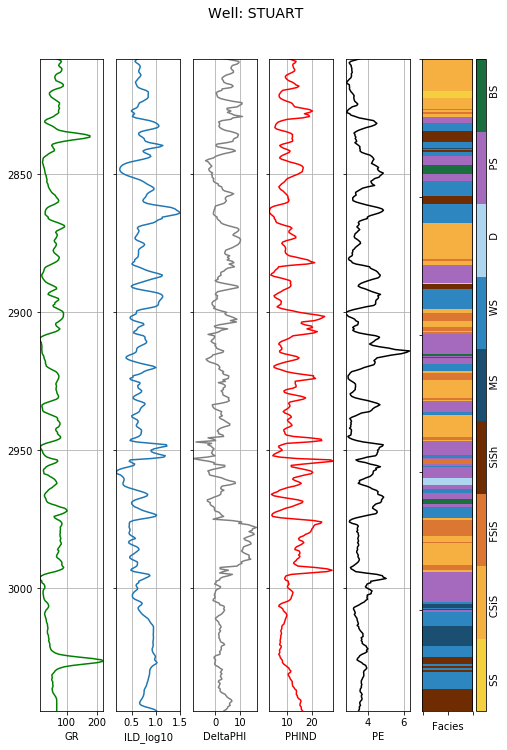

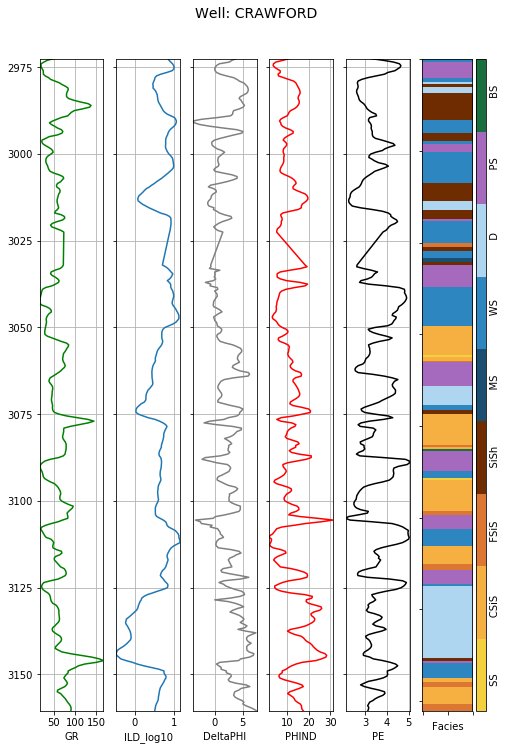

In [45]:
# Plot predicted labels
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
mpl.rcParams.update(inline_rc)

Interestingly in the test wells, there appears to be some bad data where the logs appear to be linearly interpolated, e.g. ~3025mMD in Crawford

# Future work/suggestions
* Get the TensorFlow models to work in the `VotingClassifier`
* Try a LSTM model using TensorFlow and use previous depths as features
* Try some of the interesting feature engineering solutions shown by others (e.g.  [Paolo Bestagini's work](https://github.com/seg/2016-ml-contest/blob/master/ispl/facies_classification_try02.ipynb), wavelet transforms etc.)
* Use a normalised GR - this requires a bit more info on the geology to find a fieldwide correlatable high (shale) and low (sand/carbonate) GR events
* Check for hydrocarbon bearing intervals and split the data into gas/oil and water zones. Alternatively, calculate water saturation using Archie's equation and use that as a feature (assume m = n = 2)
* Detailed log QC removing intervals that look like they have suspicious data
* Try incorporating the wells with missing PEF data. Some people have used a regression technique to predict this, but given the physics of the measurement this may/may not be appropriate
* Try using TPOT or tuning XGBoost